In [1]:
from eolearn.core import EOWorkflow, Dependency
from eolearn.core import FeatureType

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio.features
import rasterio.transform
import datetime
import os
from pathlib import Path
from math import ceil

from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# testing
import scipy.stats as stats

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
from eolearn.core import LoadFromDisk, SaveToDisk, AddFeature, EOPatch, EOTask, FeatureTypeSet, FeatureType, LinearWorkflow, EOExecutor
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.features import LinearInterpolation

In [6]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

/Users/markbogataj/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
buffer = -5
fraction_size = 0.05 # koliksen del podatkov vzame
spatial = False
window = 1 # če je 1 je per pixel, drugače pa glede na velikost okna
interpolation_range = [8]#2,4,8,16,32,64,128] # [2,4,8] # [16, 32] # [2,4,8,16,32]
mask_valid = 'VALID_DATA' # L1C_VALID changed from VALID_DATA
#resampled_range = ('2017-01-01', '2017-09-30', interpolation)
drop_classes = [1,3,4,5,8,14,16,18,19,21]
class_labels = set(list(range(1,26))) - set(drop_classes)
MAIN_FOLDER = Path('/Volumes/Seagate_drive') # spremenis na path do podatkov zip-a
DATA_FOLDER = os.path.join(MAIN_FOLDER, 'original')
DATA_LIST = os.listdir(DATA_FOLDER)
#OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'interpolation-{}days'.format(interpolation))

In [8]:
actual_fraction = fraction_size/(window*window)
print(actual_fraction, actual_fraction*(window**2))

0.05 0.05


In [9]:
non_empty_patches =[]
for name in DATA_LIST:
    if(name == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join(DATA_FOLDER, name), lazy_loading=True)
        if len(eopatch.data)!=0:
            non_empty_patches.append(name)
DATA_LIST = non_empty_patches

In [10]:
#DATA_LIST= DATA_LIST[:1]
print(len(DATA_LIST[:5]))
DATA_LIST = DATA_LIST[:15]
DATA_LIST

5


['eopatch_100_col-8_row-7',
 'eopatch_101_col-8_row-8',
 'eopatch_102_col-8_row-9',
 'eopatch_103_col-8_row-10',
 'eopatch_107_col-9_row-3',
 'eopatch_108_col-9_row-4',
 'eopatch_109_col-9_row-5',
 'eopatch_10_col-1_row-7',
 'eopatch_110_col-9_row-6',
 'eopatch_111_col-9_row-7',
 'eopatch_112_col-9_row-8',
 'eopatch_113_col-9_row-9',
 'eopatch_114_col-9_row-10',
 'eopatch_119_col-10_row-3',
 'eopatch_120_col-10_row-4']

In [11]:
class bufferPolys(EOTask):
    
    def __init__(self, features, buffer):
        self.feature_type, self.feature_name = features[0], features[1]
        self.buffer = buffer
    
    def execute(self, eop):
        # crops = eopatch.vector_timeless['LPIS_2017']
        crops = eop[self.feature_type][self.feature_name]
        crops_buffered = crops.copy(deep=True)
        # make buffer = -5
        crops_buffered.geometry = crops.buffer(self.buffer)
        crops_buffered = crops_buffered[~crops_buffered.is_empty]
        crops_buffered['SIFRA_KMRS'] = pd.to_numeric(crops_buffered['SIFRA_KMRS'])

        eop.add_feature(FeatureType.VECTOR_TIMELESS, 'LPIS_buffered', crops_buffered)
        
        return eop

In [12]:
class VectorToRasterMultiple(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def _get_shape(self, eopatch):
        if isinstance(self.raster_shape, (tuple, list)) and len(self.raster_shape) == 2:
            if isinstance(self.raster_shape[0], int) and isinstance(self.raster_shape[1], int):
                return self.raster_shape

            feature_type, feature_name = next(self._parse_features(self.raster_shape)(eopatch))
            return eopatch.get_spatial_dimension(feature_type, feature_name)

        raise ValueError('Could not determine shape of the raster image')

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height, width = self._get_shape(eopatch)
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [25]:
class VectorToRasterMultiple2(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height = eopatch[FeatureType.MASK]['IS_DATA'].shape[1] * 10
        width = eopatch[FeatureType.MASK]['IS_DATA'].shape[2] * 10
        
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [26]:
class select_bands(EOTask):
    
    def __init__(self, feature, new_feature_name, features):
        self.feature_type, self.feature_name = feature[0], feature[1]
        self.new_feature_name = new_feature_name
        self.features = features
    
    def execute(self, eop):
        bands = eop[self.feature_type][self.feature_name]
        bands_new = bands[:, :, :, self.features]
        eop.add_feature(self.feature_type, self.new_feature_name, bands_new)
        
        return eop
    
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch
    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch

In [27]:
def undersampleMajority(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction*2) # increase sample size by 2 to later reduce by 50%
    
    sampled_classes = mask[rows[sampled], cols[sampled]]
    # checking the distribution of mapped classes
    sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    values = np.unique(sampled_classes, return_counts=True)
    number_of_2 = values[1][np.where(values[0]==2)[0]][0]
    
    for location, x in enumerate(sampled_classes):
        if x in drop_classes:
            sampled_classes[location] = 0
            
    clean = sampled_classes==0
    sampled_classes = sampled_classes[~clean]
    
    sampled2 = np.random.rand(number_of_2) > (1.0 - 1/6) # we want only 1/6 of them all
        
    sub_sample = np.where(sampled_classes==2)[0][~sampled2]
    sampled[np.where(sampled==True)[0][sub_sample]]=False
    
    #sampled_classes = mask[rows[sampled], cols[sampled]]
    #sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    #values = np.unique(sampled_classes, return_counts=True)
    #distrib = np.round(values[1]/sum(values[1]), 6)
    #fig = plt.figure(figsize=(15, 15))
    #plt.bar(values[0], distrib, align='center')
    #plt.xticks(values[0], values[0]);
    
    return sampled

def sample(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction)
    return sampled

class SampleValid(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    def __init__(self, feature, fraction=1.0, no_data_value=0, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)

    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        #print(eopatch_folder)
        mask = eopatch[self.feature_type][self.feature_name].squeeze()

        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')
        
        rows, cols = np.where(mask != self.no_data_value)
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder, 'sampling.npy'))
        
        np.random.seed(seed)
        if not os.path.exists(os.path.join(OUTPUT_FOLDER, eopatch_folder)):
            os.makedirs(os.path.join(OUTPUT_FOLDER, eopatch_folder))
            
        if sampling_file.is_file():
            sampled = np.load(sampling_file)
            if not(round(np.sum(sampled)/len(rows), 2) == self.fraction):
                print("fraction mismatch")
                #sampled = undersampleMajority(mask, rows, cols, self.fraction)
                sampled = sample(mask, rows, cols, self.fraction)
                np.save(sampling_file, sampled)
            
        else:
            #sampled = undersampleMajority(mask, rows, cols, self.fraction)            
            sampled = sample(mask, rows, cols, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, sampled)
            
        rows = rows[sampled]
        cols = cols[sampled]

        for feature_type, feature_name in self.sample_features(eopatch):

            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):

                if feature_type.is_time_dependent():
                    sampled_data = eopatch[feature_type][feature_name][:, rows, cols, :]
                else:
                    sampled_data = eopatch[feature_type][feature_name][rows, cols, :]

                # here a copy of sampled array is returned and assigned to feature of a shallow copy
                # orig_eopatch[feature_type][feature_name] remains unmodified
                eopatch[feature_type][feature_name] = sampled_data[..., np.newaxis, :]

        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]        
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        return eopatch

In [28]:
class SampleValidSpatial(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    #def __init__(self, feature, fraction=1.0, window=24, no_data_value=0, increase=1, sample_features=...):
    def __init__(self, feature, fraction=1.0, window=1, no_data_value=0, increase=1, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)
        self.window = window
        self.increase = increase

    def sample_spatial(self, mask, rows, cols, fraction):

        # double the amount of sampled data to be reduced based on coverage
        sampled = np.random.rand(len(rows)) > (1.0 - self.fraction*self.increase)
        #print("sampled", np.sum(sampled), "which is", np.sum(sampled)/len(rows))
        # TODO save sampling        
        rows = rows[sampled]
        cols = cols[sampled]

        new_mask = np.array([mask[(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2))] for x,y in zip(rows,cols)])
        no_data_part = []        
        # to increase and reduce data where there is data
        if self.increase != 1:
            for x in new_mask:
                uniq = np.unique(x, return_counts=True)
                if self.no_data_value in uniq[0]:
                    number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
                    no_data_part.append(number_of_0/np.sum(uniq[1]))
                else: # in case all samples have label different from no_data_value
                    no_data_part.append(0)

            ordered = np.array(sorted(enumerate(no_data_part), key=lambda x:x[1]))
            to_keep = np.array(ordered[:(len(ordered)//self.increase),0], dtype= np.int16)
            #print(len(to_keep))
            new_mask = new_mask[to_keep]
            rows = rows[to_keep]
            cols = cols[to_keep]
            
            # testing distribution
            #print(np.unique(np.round(np.array(no_data_part)[to_keep],1), return_counts=True))
            # print(np.unique(np.round(no_data_part,1), return_counts=True))
            # fit = stats.norm.pdf(ordered[:,1], np.mean(ordered[:,1]), np.std(ordered[:,1]))
            # plt.plot(ordered[:,1], fit, '-')
            # plt.hist(ordered[:,1], normed=True)
            # plt.savefig("dist1.png")
            # #print(ordered.shape)
            # #print(ordered)

            #-----------testing distribution of no data
            # no_data_part = []
            # n_pixels=0
            # for x in new_mask:
            #     uniq = np.unique(x, return_counts=True)
            #     if self.no_data_value in uniq[0]:
            #         number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
            #         no_data_part.append(number_of_0/np.sum(uniq[1]))
            #     else: # in case all samples have label different from no_data_value
            #         no_data_part.append(0)

            # ordered = np.array(sorted(enumerate(no_data_part), key=lambda x:x[1]))

            # print(np.unique(np.round(no_data_part,1), return_counts=True))
            # fit = stats.norm.pdf(no_data_part, np.mean(no_data_part), np.std(no_data_part))
            # plt.plot(no_data_part, fit, '-')
            # plt.hist(no_data_part, normed=True)
            # plt.savefig("dist2.png")
            #print(len(ordered))
            #print(ordered)
        
        return rows, cols
       
        
    
    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        
      

        
        # new_mask = np.array([mask[(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2))] for x,y in zip(rows,cols)])
        #print(mask.shape)
        #print(new_mask.shape)
        # reducing data based on no_data_label
        
        # no_data_part = []        
        # to increase and reduce data where there is data
        # if increase != 1:
        #     for x in new_mask:
        #         uniq = np.unique(x, return_counts=True)
        #         if self.no_data_value in uniq[0]:
        #             number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
        #             no_data_part.append(number_of_0/np.sum(uniq[1]))
        #         else: # in case all samples have label different from no_data_value
        #             no_data_part.append(0)
        #         
        #     ordered = np.array(sorted(enumerate(no_data_part), key=lambda x:x[1]))
        #     to_keep = np.array(ordered[:(len(ordered)//increase),0], dtype= np.int16)
        #     #print(len(to_keep))
        #     new_mask = new_mask[to_keep]
        #     rows = rows[to_keep]
        #     cols = cols[to_keep]
        
        
        
        #-----------testing distribution of no data
        #no_data_part = []
        #n_pixels=0
        #for x in new_mask:
        #    uniq = np.unique(x, return_counts=True)
        #    number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
        #    no_data_part.append(number_of_0/np.sum(uniq[1]))
        #    n_pixels += np.sum(uniq[1])
        #    #print(uniq)
        ##print(n_pixels)
        #ordered = sorted(no_data_part)
        #fit = stats.norm.pdf(ordered, np.mean(ordered), np.std(ordered))
        #plt.plot(ordered, fit, '-')
        #plt.hist(ordered, normed=True)
        #plt.show()

        
        
         # ------------------from sampling valid
        mask = eopatch[self.feature_type][self.feature_name].squeeze()
        h, w = mask.shape
        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')

        np.random.seed(int(eopatch_folder.split('_')[1]))
        increase = 1
        rows1, cols1 = np.where(mask != self.no_data_value)
        # moving towards the inside of the patch so patch is defined in sampled area
        clean = np.logical_and(rows1>=self.window//2, rows1<=(h-ceil(self.window/2)))
        # #print("bounds x", len(rows)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        clean = np.logical_and(cols1>=self.window//2, cols1<=(w-ceil(self.window/2)))
        #print("bounds y", len(cols)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        

               
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder+'sampling.npy'))
        np.random.seed(seed)
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
            
        if sampling_file.is_file(): # not loading fraction beacause just one interpolation sampling_file.is_file():
            rows, cols = np.load(sampling_file, allow_pickle=True)
            if not(round(len(rows)/len(rows1), 3) == self.fraction):
                print("fraction mismatch", round(len(rows)/len(rows1), 3), self.fraction)
                #rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction)
                #np.save(sampling_file, (rows, cols))
            
        else:
            rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, (rows, cols))
            
        #rows = rows[sampled]
        #cols = cols[sampled] #empty
        
        for feature_type, feature_name in self.sample_features(eopatch):
            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):
                if feature_type.is_time_dependent():
                    sampled_data = np.array([eopatch[feature_type][feature_name][:,(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    sampled_data = np.transpose(sampled_data, (1, 0, 2, 3, 4))
                    t,s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(t,s,wi*he,b)
                else:
                    sampled_data = np.array([eopatch[feature_type][feature_name][(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(s,wi*he,b)
        
                eopatch[feature_type][feature_name] = sampled_data
        
        #print(list(zip(rows, cols))[:10])
        #print(mask[rows[:10], cols[:10]])
        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        return eopatch

In [29]:
def get_group_id(crop_group, crop_group_df, group_name='CROP_ID',
             group_id='GROUP_1', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

def get_numeric_group(crop_group, crop_group_df, group_name='GROUP_1_NAME',
                 group_id='GROUP_1_ID', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

class group_crops_spatial(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        arr = []
        if eop.mask_timeless['LPIS_sifra'].shape[1] == 1:
               arr = [[get_numeric_group(get_group_id(str(y).zfill(3), self.lpis_to_group), self.group_to_numeric)] for y in eop.mask_timeless['LPIS_sifra'].squeeze()]
        else: 
            for y in eop.mask_timeless['LPIS_sifra'].squeeze():
                arr.append([get_numeric_group(get_group_id(str(x).zfill(3), self.lpis_to_group), self.group_to_numeric) for x in y])
                    #print(np.unique(arr[-1], return_counts=True))
                #break
        #print(eop.mask_timeless['LPIS_sifra'].squeeze()[np.where(np.array(arr) == 23)])
        arr = np.array(arr)
        #aar shape[1] is 1 when no spatial data is included
        eop.mask_timeless['LPIS_sifra'] = arr[...,np.newaxis]
        #print(np.unique(arr, return_counts=True))
        return eop
    
class group_crops(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        # print(np.unique(eop.mask_timeless['LPIS_sifra'], return_counts=True))
        groups = list(get_group_id(str(x).zfill(3), self.lpis_to_group) for x in eop.mask_timeless['LPIS_sifra'].squeeze())
        # print(np.unique(groups, return_counts=True))
        tt = np.array([get_numeric_group(x, self.group_to_numeric) for x in groups])
             # np.array(list(get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled.mask_timeless['LPIS_sifra']))
        # print(np.unique(tt, return_counts=True))
        eop.mask_timeless['LPIS_sifra'] = tt.reshape([len(tt),1,1])
        # eop.data['BANDS-S2-L2A'] = np.squeeze(eop.data['BANDS-S2-L2A'], axis=2)
        # eop.mask_timeless['PID'] = np.squeeze(eop.mask_timeless['PID'])
        return eop

In [30]:
buffer_poly = bufferPolys((FeatureType.VECTOR_TIMELESS, 'LPIS_2017_org'), buffer)

load = LoadFromDisk(folder=DATA_FOLDER, lazy_loading=True)


vec_to_ras_lpis = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint16, no_data_value=0)

vec_to_ras_pid = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'PID'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'GERK_PID', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint32, no_data_value=0)

vec_to_multi_raster = VectorToRasterMultiple2((FeatureType.MASK_TIMELESS, 'LPIS_MULTI'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint32, no_data_value=0)


# [(FeatureType.DATA, 'BANDS-S2-L2A'), (FeatureType.MASK, mask_valid), FeatureType.MASK_TIMELESS])
sampling = SampleValidSpatial((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                       fraction=actual_fraction, no_data_value=0,
                                window=window, increase=2,
                       sample_features=[(FeatureType.DATA, 'BANDS-S2-L2A'),
                                        (FeatureType.MASK, mask_valid),
                                        FeatureType.MASK_TIMELESS])

#B(B02), G(B03), R(B04), NIR (B08)
custom_bands = [2, 3, 4, 8]
select = select_bands((FeatureType.DATA, 'BANDS-S2-L2A'), 'BANDS', custom_bands)

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

lpis_to_group = pd.read_csv(os.path.join(MAIN_FOLDER,"crop-definitions/slo_lpis_crop_to_group_mapping_20190517.csv"))
group_to_numeric = pd.read_csv(os.path.join(MAIN_FOLDER,"crop-definitions/crop_group_1_definition_20190517.csv"))
grouping = group_crops_spatial(lpis_to_group, group_to_numeric)

#if spatial:
#    sampling = SampleValidSpatial((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
#                                 fraction=fraction_size, no_data_value=0, window=window,
#                                  sample_features=[(FeatureType.DATA, 'BANDS-S2-L2A'),
#                                                   (FeatureType.MASK, mask_valid), FeatureType.MASK_TIMELESS])
#    # TODO test group_crops(lpis_to_group, group_to_numeric)
#    grouping = group_crops_spatial(lpis_to_group, group_to_numeric)
#
#else:
#    sampling = SampleValid((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
#                                 fraction=fraction_size, no_data_value=0, sample_features=[(FeatureType.DATA, 'BANDS-S2-L2A'), (FeatureType.MASK, mask_valid), FeatureType.MASK_TIMELESS])
#    grouping = group_crops(lpis_to_group, group_to_numeric)


/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:166: DeprecationWarning: This task is deprecated, use LoadTask instead
  warnings.warn('This task is deprecated, use LoadTask instead', DeprecationWarning)


In [31]:
# def eojob(i):
    # eopatch = eopatch_names[i]
    # print(i)
    #result = workflow.execute(i)
        #{load: {'eopatch_folder': eopatch}, 
                               #validate_gbm: {'labels': classifier1.classes_},
                               #save: {'eopatch_folder': eopatch}
                              #})
#     del result

# save for different interpolations
print(str(window) +'_' + str(int(actual_fraction*(window**2)*100)).zfill(2))
for interpolation in interpolation_range[::-1]:
    resampled_range = ('2017-01-01', '2017-09-30', interpolation)
#     OUTPUT_FOLDER = os.path.join("/Volumes/Seagate_drive", 'aFractionIndices{}'.format(str(window)+'_'+str(int(actual_fraction*(window**2)*100)).zfill(2)),  'interpolation-{}days'.format(interpolation))
    OUTPUT_FOLDER = os.path.join("./", 'aFractionIndices{}'.format(str(window)+'_'+str(int(actual_fraction*(window**2)*100)).zfill(2)),  'interpolation-{}days'.format(interpolation))
    
    # workflow
    linear_interp = LinearInterpolation(
        (FeatureType.DATA,'FEATURES'), # 'BANDS-S2-L2A'
        mask_feature=(FeatureType.MASK, mask_valid), # mask to be used in interpolation TODO change from VALID_DATA
        copy_features=[(FeatureType.MASK_TIMELESS, 'LPIS_sifra'), (FeatureType.MASK_TIMELESS, 'PID'), (FeatureType.MASK_TIMELESS, 'LPIS_MULTI')], # features to keep
        resample_range=resampled_range, # set the resampling range
        bounds_error=False # extrapolate with NaN's
    )

    save = SaveToDisk(OUTPUT_FOLDER, overwrite_permission = 1)
    exec_params = []
    for name in DATA_LIST:  # [filename for filename in DATA_LIST if 'col-21_row-20' in filename]:
        #name = filename.rsplit('/', 1)[1]
        exec_params.append({
            load: dict(eopatch_folder=name),
            save: dict(eopatch_folder=name),
            sampling: dict(eopatch_folder=name, OUTPUT_FOLDER=OUTPUT_FOLDER)
        })
    
    workflow = LinearWorkflow(load, buffer_poly, vec_to_ras_lpis, vec_to_ras_pid, vec_to_multi_raster, sampling, select, ndvi, ndwi, norm, concatenate, linear_interp, grouping, save)
    executor = EOExecutor(workflow, exec_params, save_logs=True)
    print("Working on", interpolation, "days,", "saving to", OUTPUT_FOLDER)
    executor.run(workers=1)
#     workflow.execute(exec_params[0])

1_05
Working on 8 days, saving to ./aFractionIndices1_05/interpolation-8days


/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:127: DeprecationWarning: This task is deprecated, use SaveTask instead
  warnings.warn('This task is deprecated, use SaveTask instead', DeprecationWarning)


fraction mismatch 0.051 0.05
fraction mismatch 0.051 0.05



In [32]:
executor.make_report()

In [21]:
os.listdir('./aFractionIndices1_05/interpolation-8days')

['eopatch_108_col-9_row-4',
 'eopatch_120_col-10_row-4',
 'eopatch_110_col-9_row-6',
 '.DS_Store',
 'eopatch_111_col-9_row-7sampling.npy',
 'eopatch_110_col-9_row-6sampling.npy',
 'eopatch_107_col-9_row-3sampling.npy',
 'eopatch_114_col-9_row-10sampling.npy',
 'eopatch_101_col-8_row-8sampling.npy',
 'eopatch_107_col-9_row-3',
 'eopatch_112_col-9_row-8sampling.npy',
 'eopatch_113_col-9_row-9sampling.npy',
 'eopatch_100_col-8_row-7',
 'eopatch_113_col-9_row-9',
 'eopatch_119_col-10_row-3',
 'eopatch_103_col-8_row-10',
 'eopatch_10_col-1_row-7',
 'eopatch_10_col-1_row-7sampling.npy',
 'eopatch_102_col-8_row-9sampling.npy',
 'eopatch_109_col-9_row-5',
 'eopatch_100_col-8_row-7sampling.npy',
 'eopatch_102_col-8_row-9',
 'eopatch_111_col-9_row-7',
 'eopatch_108_col-9_row-4sampling.npy',
 'eopatch_109_col-9_row-5sampling.npy',
 'eopatch_120_col-10_row-4sampling.npy',
 'eopatch_101_col-8_row-8',
 'eopatch_112_col-9_row-8',
 'eopatch_114_col-9_row-10',
 'eopatch_103_col-8_row-10sampling.npy',
 

In [33]:
eopatch1 = EOPatch.load(os.path.join(DATA_FOLDER, 'eopatch_108_col-9_row-4'))
eopatch1

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=4573, crs=EPSG:32633)
    LPIS_2017_org: geopandas.GeoDataFrame(columns=['KM

In [34]:
eopatch = EOPatch.load(os.path.join('./aFractionIndices1_05/interpolation-8days', DATA_LIST[1]))

In [35]:
eopatch

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 10721, 1, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_MULTI: numpy.ndarray(shape=(10721, 1, 1), dtype=uint32)
    LPIS_sifra: numpy.ndarray(shape=(10721, 1, 1), dtype=int64)
    PID: numpy.ndarray(shape=(10721, 1, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5105816.813818144), (461269.3104915918, 5115262.978997778)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

In [12]:
features_arr = eopatch.data['FEATURES'].copy()
lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()
pid_data_arr = eopatch.mask_timeless['PID'].copy()
print(features_arr.shape)
print(lpis_data_arr.shape)
print(pid_data_arr.shape)

NameError: name 'eopatch' is not defined

In [16]:
features_arr[:][0].shape

(10721, 1, 7)

In [17]:
eopatch.data['FEATURES'][:][0].shape

(10721, 1, 7)

In [18]:
features_arr[0][1][0]

array([nan, nan, nan, nan, nan, nan, nan])

In [19]:
pid_data_arr[1][0][0]

4079720

In [56]:
list_of_cells = []
list_of_groundtruth = []

list_of_all_LPIS_data = []

for idx in range(0, len(DATA_LIST)):
    
    if(DATA_LIST[idx] == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join('./aFractionIndices1_05/interpolation-8days', DATA_LIST[idx]))

        features_arr = eopatch.data['FEATURES'].copy()
        lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()
        pid_data_arr = eopatch.mask_timeless['PID'].copy()


        num_of_days = features_arr.shape[0]
        num_of_cells = features_arr.shape[1]
        num_of_features = features_arr.shape[3]

        for k in range(0, num_of_cells):

            tmp_arr = np.zeros((34,7))

            for i in range(0, num_of_days):
                for j in range(0, num_of_features):
                    tmp_arr[i][j] = features_arr[i][k][0][j]

            list_of_cells.append(tmp_arr)

            tupl = (lpis_data_arr[k][0][0], pid_data_arr[k][0][0])
            list_of_groundtruth.append(tupl)
            list_of_all_LPIS_data.append([lpis_data_arr[k][0][0]])

print(len(list_of_cells), list_of_cells[0].shape)
print(len(list_of_groundtruth))
print(len(list_of_all_LPIS_data))

107531 (34, 7)
107531
107531


In [57]:
np.save('./testni_input_file.npy', list_of_cells)
np.save('./ground_truth_file.npy', list_of_groundtruth)
# np.save('./LPIS_ground_truth.npy', LPIS_GT_popravljeno)
np.save('./LPIS_ground_truth.npy', list_of_all_LPIS_data)

In [58]:
loaded_data = np.load('./testni_input_file.npy')
loaded_gt = np.load('./ground_truth_file.npy')
loaded_LPIS_gt = np.load('./LPIS_ground_truth.npy')

In [180]:
[[x,list_of_all_LPIS_data.count(x)] for x in set(list_of_all_LPIS_data)]

[[1, 2],
 [2, 63550],
 [3, 45],
 [4, 100],
 [7, 1510],
 [9, 213],
 [10, 17910],
 [11, 9695],
 [12, 7441],
 [13, 26],
 [14, 34],
 [15, 1105],
 [16, 30],
 [17, 1402],
 [18, 105],
 [20, 1959],
 [21, 19],
 [22, 477],
 [23, 1313],
 [24, 332],
 [25, 263]]

In [37]:
eopatch = EOPatch.load(os.path.join(DATA_FOLDER, 'eopatch_108_col-9_row-4'))
eopatch

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=4573, crs=EPSG:32633)
    LPIS_2017_org: geopandas.GeoDataFrame(columns=['KM

In [38]:
bbox_poly = eopatch.bbox.geometry
vector_data = eopatch[FeatureType.VECTOR_TIMELESS]['LPIS_2017']
        
vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
vector_data.geometry = vector_data.geometry.buffer(0)
vetor_data = vector_data[vector_data.geometry.is_valid]
vetor_data = vector_data[~vector_data.geometry.is_empty]
        
filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
pairs = []
for idx, row in filtered_data.iterrows():
    pairs.append((row.geometry, row['SIFRA_KMRS']))


bbox_map = pairs 
height = eopatch[FeatureType.MASK]['IS_DATA'].shape[1] * 10
width = eopatch[FeatureType.MASK]['IS_DATA'].shape[2] * 10
        
data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

# raster = eopatch[FeatureType.MASK_TIMELESS]['TEST'].squeeze()
raster = np.ones((height, width), dtype=np.uint32) * np.nan

if len(bbox_map):
    rasterio.features.rasterize(bbox_map, out=raster,
                                transform=data_transform,
                                dtype=np.uint32)

eopatch[FeatureType.MASK_TIMELESS]['TEST'] = raster[..., np.newaxis]

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55c0eef0> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55c0eef0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c53b2f668>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55c0eef0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55c0eef0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c53b2f668>


In [39]:
from eolearn.geometry import VectorToRaster

rasterize = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, 'LPIS_2017'),
                           raster_feature=(FeatureType.MASK_TIMELESS, 'LPIS_2017'),
                           values=None,
                           values_column='SIFRA_KMRS',
                           raster_shape=(FeatureType.DATA,'BANDS-S2-L2A'),
                           raster_dtype=np.int16,
                           no_data_value=0)
rasterize.execute(eopatch)

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c55136080> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c55136080>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c545700b8>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c55136080> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c55136080>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c545700b8>


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_2017: numpy.ndarray(shape=(945, 969, 1), dtype=int16)
    TEST: numpy.ndarray(shape=(9450, 9690, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_I

In [40]:
eopatch

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(10, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(10, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(10, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_2017: numpy.ndarray(shape=(945, 969, 1), dtype=int16)
    TEST: numpy.ndarray(shape=(9450, 9690, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_I

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Heavy.otf) normal normal heavy normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.o

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: sco

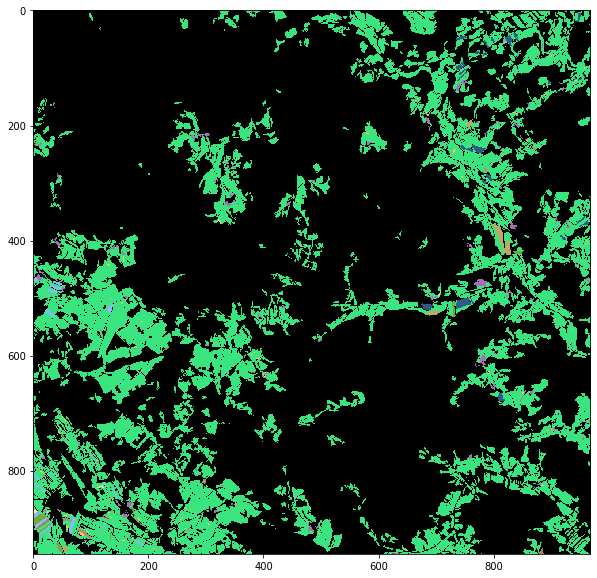

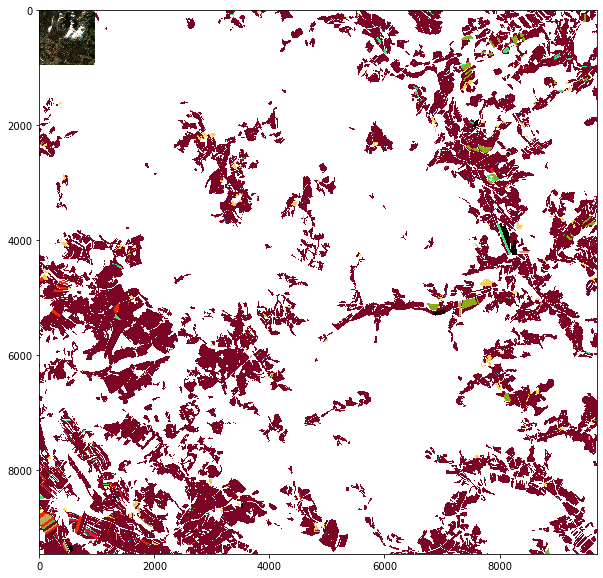

In [41]:
%matplotlib inline
import matplotlib

custom_colors = matplotlib.colors.ListedColormap(['xkcd:Black', # no class #NA
                'xkcd:reddish purple', # pesa #NA
                'xkcd:camouflage green', # kosen travnik
                'xkcd:sandy brown', # praha #NA
                'xkcd:pea green', # grah #NA
                'xkcd:lawn green', # pasnik #NA
                'xkcd:leaf', # hmelj
                'xkcd:light navy blue', #pale olive green', # trave
                'xkcd:tomato red', # mak #NA
                'xkcd:sandy brown', # ozimna oljna ogrscica mustard yellow
                'xkcd:maize', # 10 koruza
                'xkcd:carolina blue', # ozimna zita wheat
                'xkcd:soft purple', # metuljcnice deteljica
                'xkcd:pumpkin orange', # buce
                'xkcd:cranberry', # jagodicevje #NA
                'xkcd:golden', #15 jara zita
                'xkcd:sunflower', # soncnice #NA
                'xkcd:pinkish red', # zelenjava
                'xkcd:pale brown', # ajda #NA
                'xkcd:nasty green', # gorski travnik #NA
                'xkcd:light brown', # krompir
                'xkcd:pea soup', # strocnice #NA
                'xkcd:wine red', # vinogradi
                'xkcd:weird green', # drugo
                'xkcd:pale yellow', # soja
                'xkcd:browny orange' # sadno drevje
                ])

image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(eopatch.mask_timeless['LPIS_2017'])
mask_test = np.squeeze(eopatch.mask_timeless['TEST'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image)
ax0.imshow(mask, cmap=custom_colors, alpha=1)

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.imshow(image)
ax1.imshow(mask_test, cmap=custom_colors, alpha=1)

In [39]:
maska1 = mask.flatten()
maska2 = mask_test.flatten()

In [40]:
maska1 = list(maska1)
maska2 = list(maska2)

In [41]:
[[x,maska1.count(x)] for x in set(maska1)]

[[0, 701134],
 [139, 99],
 [140, 51],
 [146, 38],
 [23, 634],
 [24, 291],
 [154, 5],
 [27, 14],
 [157, 202262],
 [29, 20],
 [159, 764],
 [162, 1288],
 [164, 17],
 [166, 65],
 [42, 58],
 [45, 15],
 [46, 680],
 [177, 4],
 [52, 2065],
 [53, 19],
 [56, 2],
 [58, 27],
 [69, 771],
 [75, 1434],
 [82, 688],
 [84, 2731],
 [86, 50],
 [113, 10],
 [115, 18],
 [119, 39],
 [120, 8],
 [123, 56],
 [125, 93],
 [126, 255]]

In [42]:
[[x,maska2.count(x)] for x in set(maska2)]

[[0, 70094798],
 [139, 9960],
 [140, 5036],
 [146, 4027],
 [23, 63922],
 [24, 29383],
 [154, 411],
 [27, 1376],
 [157, 20238970],
 [29, 1732],
 [159, 76239],
 [162, 131299],
 [164, 1682],
 [166, 6640],
 [42, 5579],
 [45, 1430],
 [46, 68710],
 [177, 476],
 [52, 206232],
 [53, 2070],
 [56, 134],
 [58, 2583],
 [69, 77871],
 [75, 142658],
 [82, 69046],
 [84, 274461],
 [86, 5269],
 [113, 975],
 [115, 2056],
 [119, 4052],
 [120, 854],
 [123, 5412],
 [125, 9082],
 [126, 26075]]